In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('C:/Users/DENVER/Udacity/machine-learning\projects/toxic-comment-classification/train.csv')#load the dataset
test_data = pd.read_csv('C:/Users/DENVER/Udacity/machine-learning\projects/toxic-comment-classification/test.csv')
data.head() # have a look at the data


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [2]:
data.isnull().any() # check for empty entries


id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [3]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# function to remove stop-words, numbers, and punctuation from comments
def clean_data(data):
    clean_data = [] 
    for text in data:
        text = text_to_word_sequence(text)
        text = [word for word in text if  word.isalpha() and word not in stop_words]
        clean_data.append(text)

    return clean_data


Using TensorFlow backend.


In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
comments_train, comments_test, labels_train, labels_test = train_test_split(data['comment_text'],\
                data[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=42)


In [5]:
# clean train and test data 
comments_train = clean_data(comments_train)
comments_test = clean_data(comments_test)

#keep this ones for kaagle score
kaggle_train = clean_data(data['comment_text'])
kaggle_labels = data[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
kaggle_test = clean_data(test_data['comment_text'])


In [6]:
# import keras library for preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 20000  # maximum number of common wards to be considered
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(comments_train) # fit tokenizer on comments_train


In [7]:
# turn senteces into sequences 
tokenized_comments_train = tokenizer.texts_to_sequences(comments_train)
tokenized_comments_test = tokenizer.texts_to_sequences(comments_test)
tokenized_kaggle_train = tokenizer.texts_to_sequences(kaggle_train)
tokenized_kaggle_test = tokenizer.texts_to_sequences(kaggle_test)


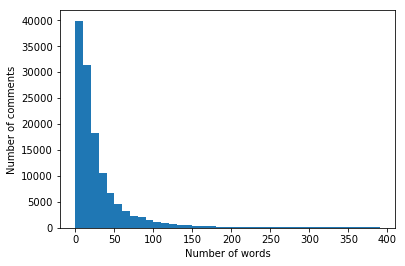

In [8]:
# visualize data to see distribution of number of  wards in comments 
senteces_length = [len(comment) for comment in tokenized_comments_train]

plt.hist(senteces_length, bins=np.arange(0, 400, 10))
plt.ylabel('Number of comments')
plt.xlabel('Number of words')
plt.show()

In [9]:
# turn senteces to the same lenght(maxlen)
comments_length = 180 # max length for each comment 
pad_comments_train = pad_sequences(tokenized_comments_train, maxlen=comments_length )
pad_comments_test = pad_sequences(tokenized_comments_test, maxlen=comments_length)
pad_kaggle_train = pad_sequences(tokenized_kaggle_train, maxlen=comments_length)
pad_kaggle_test = pad_sequences(tokenized_kaggle_test, maxlen=comments_length)


In [10]:
#import model and layers from keras library 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.layers import LSTM, GRU, BatchNormalization, Bidirectional

model = Sequential()
model.add(Embedding(max_words, 130, input_length=comments_length))
#model.add(Conv1D(filters=20,kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(60,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(50,return_sequences=True)))
#model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(42, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 130)          2600000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 130)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180, 120)          91680     
_________________________________________________________________
dropout_2 (Dropout)          (None, 180, 120)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 180, 100)          51300     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [11]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

# function to callback ROC AUC score after each epoch
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


In [12]:
from keras.callbacks import ModelCheckpoint

# save weight when there is a loss improvement
checkpointer = ModelCheckpoint(filepath='weights.best.h5py', verbose=1, save_best_only=True)

#compile the model 
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

#split data to a training and validation sets (validation set is 10%)
x_val = pad_comments_train[114890:]
y_val = labels_train[114890:]
x_train = pad_comments_train[:114890]
y_train = labels_train[:114890]

#fit the data
model.fit(x_train,y_train, validation_data=(x_val, y_val), epochs=4, batch_size=25, verbose=1,\
          callbacks=[roc_callback(training_data=(x_train,y_train),validation_data=(x_val, y_val)), checkpointer])

Train on 114890 samples, validate on 12766 samples
Epoch 1/4
114890/114890 [==============================] - 20042s 174ms/step - loss: 0.0661 - acc: 0.9787 - val_loss: 0.0552 - val_acc: 0.9795
roc-auc: 0.98 - roc-auc_val: 0.9754                                                                                                    

Epoch 00001: val_loss improved from inf to 0.05518, saving model to weights.best.h5py
Epoch 2/4
114890/114890 [==============================] - 3071s 27ms/step - loss: 0.0472 - acc: 0.9827 - val_loss: 0.0505 - val_acc: 0.9805
roc-auc: 0.988 - roc-auc_val: 0.9786                                                                                                    

Epoch 00002: val_loss improved from 0.05518 to 0.05055, saving model to weights.best.h5py
Epoch 3/4
114890/114890 [==============================] - 3029s 26ms/step - loss: 0.0414 - acc: 0.9842 - val_loss: 0.0522 - val_acc: 0.9808
roc-auc: 0.9919 - roc-auc_val: 0.9774                                    

In [13]:
#load the weights with the best loss value
model.load_weights('weights.best.h5py')


In [14]:
# save predictions 
pre = model.predict(pad_comments_test)


In [15]:
from sklearn.metrics import roc_auc_score

print (roc_auc_score(labels_test, pre),'\n')
#count mean column-wise ROC AUC score
roc_auc = []
for i in range(6):
    score = roc_auc_score(labels_test.iloc[:,i], pre[:,i])
    roc_auc.append(score)
    print (score)
    
mean_roc_auc = sum(roc_auc)/6
mean_roc_auc

0.979105901162 

0.974300876177
0.987969885445
0.989203936825
0.973973298068
0.980334045764
0.968853364691


0.97910590116180696

In [ ]:
#now train on all available training data for kaggle
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.fit(pad_kaggle_train, kaggle_labels,epochs=3, batch_size=25, validation_split=0.1, callbacks=[checkpointer], verbose=1)


Train on 143613 samples, validate on 15958 samples
Epoch 1/3
 54800/143613 [==========>...................] - ETA: 45:22 - loss: 0.0447 - acc: 0.9832

In [52]:
model.load_weights('weights.best.h5py')


In [53]:
#save predictions for kaggle test data
predicted = model.predict(pad_kaggle_data)


In [54]:
#save predictions in pandas DataFrame
submission = pd.DataFrame(predicted, index=test_data['id'],\
                          columns=['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

#load prediction to the submission.csv file
submission.to_csv("submission.csv")
